values
METFORMIN_C
1    373
0    298
Name: count, dtype: int64
Epoch [50/200], Loss: 0.0000, DCor: 0.1023
Epoch [100/200], Loss: 0.0000, DCor: 0.1023
Epoch [150/200], Loss: 0.0000, DCor: 0.1023
Epoch [200/200], Loss: 0.0000, DCor: 0.1023


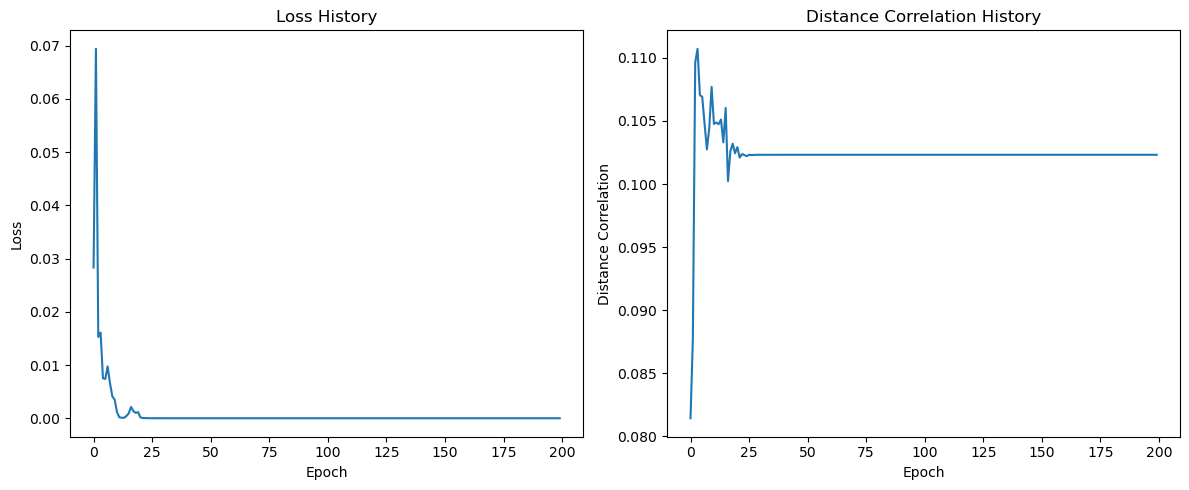

Test Inputs:  tensor([[-0.0624,  0.7552,  0.1735,  ...,  1.2110, -2.0093,  0.2386],
        [ 2.1766,  1.6877,  0.7163,  ..., -0.0831, -1.2847,  0.8356],
        [ 1.1526, -0.1680, -0.8788,  ...,  0.1723,  0.0886, -0.4749]])
Predictions (Probabilities):  tensor([[0.6037],
        [0.5254],
        [0.5874]])


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

# Simple Feedforward Neural Network
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid to get probabilities between 0 and 1

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        hidden_activations = out.clone()  # Get activations after ReLU
        out = self.fc2(out)
        out = self.sigmoid(out)  # Apply sigmoid activation to get probabilities
        return out, hidden_activations  # Return both output and hidden activations

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

# Generate synthetic data with 654 features and imbalanced labels
def generate_synthetic_data():
    

    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    print("values")
    print(metadata['METFORMIN_C'].value_counts())
    features = relative_abundance.drop(columns=['SampleID']).values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(metadata['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
    return x , y

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, num_epochs=500):
    loss_history = []
    dcor_history = []
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        hidden_activations_list = []
        targets_list = []
        
        for x_batch, y_batch in data_loader:
            # Forward pass
            outputs, hidden_activations = model(x_batch)
            loss = criterion(outputs, y_batch)
            
            # Collect hidden activations and targets
            hidden_activations_list.append(hidden_activations.detach().cpu())
            targets_list.append(y_batch.detach().cpu())
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
    
        avg_loss = epoch_loss / len(data_loader)
        loss_history.append(avg_loss)
        
        # After epoch, concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return loss_history, dcor_history



# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    hidden_size = 32
    output_size = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_synthetic_data()

    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    import math

    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    # Define model, loss, and optimizer
    model = SimpleModel(input_size, hidden_size, output_size)
    criterion = PearsonCorrelationLoss()  # Use correlation loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    loss_history, dcor_history = train_model(model, criterion, optimizer, data_loader, num_epochs)

    # Plot the loss history and distance correlation history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(dcor_history)
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.tight_layout()
    plt.show()

    # Testing the model with new data
    model.eval()
    with torch.no_grad():
        test_x = torch.randn(3, input_size)  # Test inputs with 654 features
        predictions, _ = model(test_x)
        print("Test Inputs: ", test_x)
        print("Predictions (Probabilities): ", predictions)
